In [1]:
from fastai import *
from fastai.vision import *

%matplotlib inline

PATH = os.path.abspath('..')

seed = 12345

In [2]:
sys.path.append(f'{PATH}/src')

from mxresnet import *
from ranger import Ranger

Mish activation loaded...
Mish activation loaded...


# Set up

In [3]:
xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

In [4]:
df = pd.read_csv(f"{PATH}/data/xGASS_representative_sample.csv")
df['logfgas'] = df.lgMHI - df.lgMstar

In [9]:
src = (
    ImageList.from_df(
        df, path=PATH, folder="images-xGASS-legacy", suffix=".jpg", cols="GASS"
    )
    .split_by_rand_pct(0.2, seed=seed)
    .label_from_df(cols=["logfgas"], label_cls=FloatList)
)

data = (
    src.transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(xGASS_stats)
)

In [10]:
model = mxresnet34()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True) #.cuda()

In [11]:
learn = Learner(
    data,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

# Train

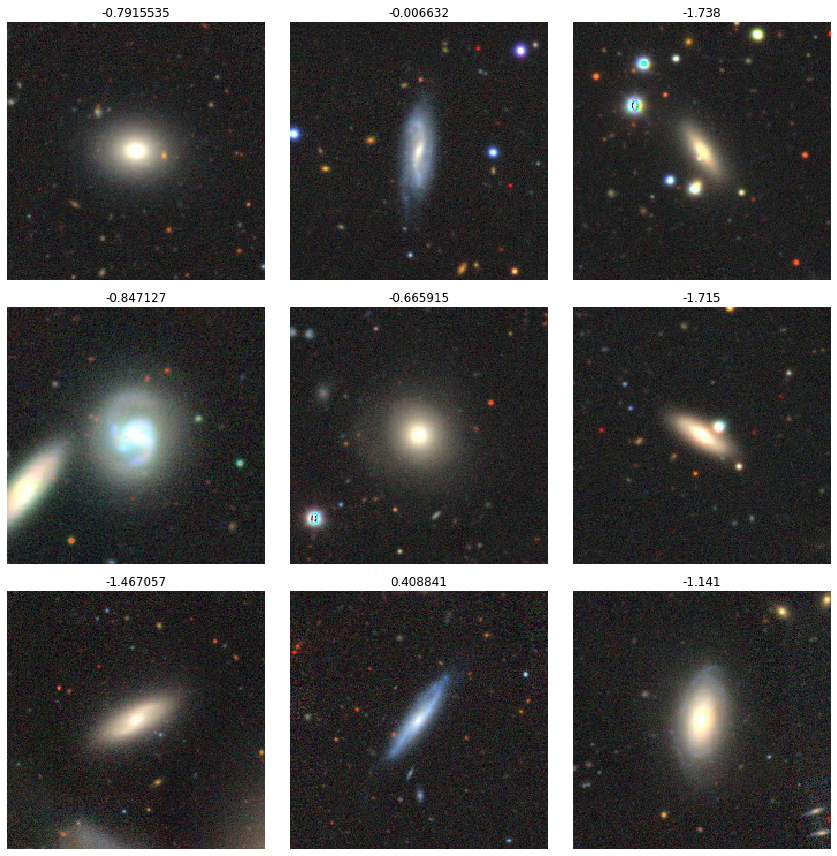

In [13]:
learn.data.show_batch(3)

In [14]:
learn.fit_one_cycle(
    cyc_len=40,
    max_lr=10e-2,
)

epoch,train_loss,valid_loss,time
0,0.953951,0.860460,00:05
1,0.665351,0.610156,00:05
2,0.541070,0.380494,00:05
3,0.478846,0.580032,00:05
4,0.454997,0.539790,00:05
5,0.437731,0.397174,00:05
6,0.430047,0.556811,00:05
7,0.428995,0.504361,00:05
8,0.440206,0.689974,00:05
9,0.442834,0.428767,00:05


In [15]:
learn.save('xgass-legacy')

# Evaluate

In [16]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2609)

In [17]:
results = pd.DataFrame({'fgas_pred': fgas_pred.squeeze(), 'fgas_true': fgas_true.squeeze()})
results['GASS'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('GASS', drop=True, inplace=True)


results.to_csv(f'{PATH}/results/predictions/xgass-legacy.csv')